# Assignment - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [1]:
# student details 1: Bar L. 7886

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name: 
Goal:

Prompt1:

Prompt2:

Prompt3:

Other assistance: None
</pre>

## Part 1(c) - Learning Problem and dataset explaination.
* Please explain in one paragraph
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add explaining text:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>
This is a binary classification problem: predicting if a passenger on the Titanic survived (1) or not (0).  
The dataset includes features such as age, sex, passenger class, number of family members, ticket fare, and embarkation port.  
The goal is to train a model on the training data to correctly predict the Survived column on the test set.
</pre>

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import f1_score, classification_report, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)


In [3]:
ntrain_path = "Titanic Train Dataset.csv"
test_path  = "Titanic Test Dataset.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

display(train_df.head())
display(test_df.head())

Train shape: (712, 8)
Test shape : (179, 8)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


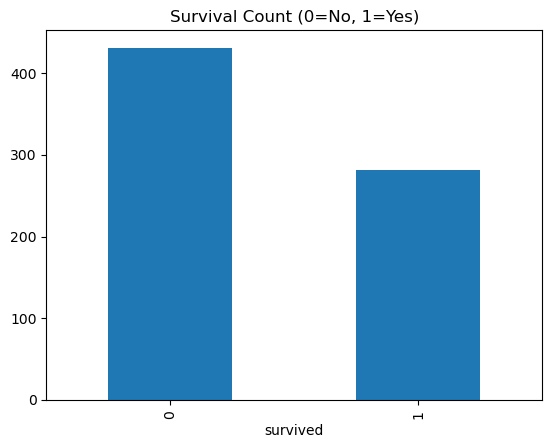

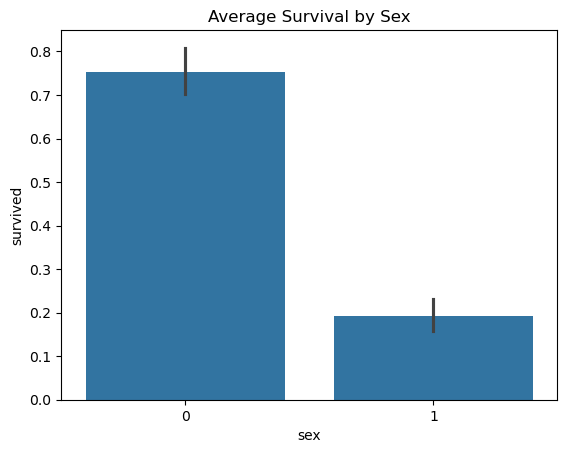

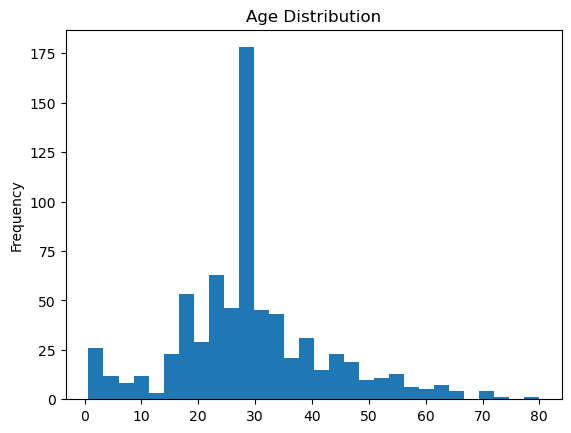

In [4]:

def normalize_cols(df):
    mapping = {c: c.strip().lower().replace(" ", "_") for c in df.columns}
    df = df.rename(columns=mapping)
    alias = {
        'pclass':'pclass', 'p_class':'pclass',
        'sex':'sex',
        'age':'age',
        'sibsp':'sibsp', 'sib_sp':'sibsp',
        'parch':'parch',
        'fare':'fare',
        'embarked':'embarked',
        'ticket':'ticket',
        'passengerid':'passenger_id', 'passenger_id':'passenger_id',
        'survived':'survived'
    }
    for old in list(df.columns):
        if old in alias and old != alias[old]:
            df = df.rename(columns={old: alias[old]})
    return df

train_df = normalize_cols(train_df)
test_df  = normalize_cols(test_df)


if 'survived' in train_df.columns:
    train_df['survived'].value_counts().plot(kind='bar')
    plt.title('Survival Count (0=No, 1=Yes)')
    plt.show()

if {'survived','sex'}.issubset(train_df.columns):
    sns.barplot(x='sex', y='survived', data=train_df, estimator=np.mean)
    plt.title('Average Survival by Sex')
    plt.show()

if 'age' in train_df.columns:
    train_df['age'].dropna().plot(kind='hist', bins=30)
    plt.title('Age Distribution')
    plt.show()

## Part 3 - Experiments
You could add as many code cells as needed

In [5]:

for df in [train_df, test_df]:
    if 'sibsp' in df.columns and 'parch' in df.columns:
        df['family_size'] = df['sibsp'] + df['parch'] + 1
        df['is_alone'] = (df['family_size'] == 1).astype(int)


In [6]:
# Define target and features
y = train_df['survived']
X = train_df.drop(columns=['survived'])

id_col = None
for cand in ['passenger_id','id']:
    if cand in X.columns:
        id_col = cand
        break

drop_cols = []
if 'ticket' in X.columns: drop_cols.append('ticket')
if id_col is not None: drop_cols.append(id_col)

X = X.drop(columns=drop_cols, errors='ignore')
X_test_raw = test_df.drop(columns=drop_cols, errors='ignore')
test_ids = test_df[id_col] if id_col and id_col in test_df.columns else None

In [7]:

numeric_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_tf = Pipeline([("imputer", SimpleImputer(strategy="median")),
                       ("scaler", StandardScaler())])
categorical_tf = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                           ("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer([("num", numeric_tf, numeric_features),
                                ("cat", categorical_tf, categorical_features)])

In [8]:
# Define models
logreg = LogisticRegression(max_iter=200, solver="liblinear")
rf = RandomForestClassifier(random_state=42)

base_pipeline = Pipeline([("prep", preprocess),
                          ("clf", logreg)])

param_grid = [
    {"clf": [logreg], "clf__penalty": ["l1","l2"], "clf__C": [0.1,1.0,10.0]},
    {"clf": [rf], "clf__n_estimators": [100,200], "clf__max_depth": [3,5,None]}
]

In [9]:
# GridSearchCV with 5-fold
cv = KFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, pos_label=1)

grid = GridSearchCV(base_pipeline, param_grid, scoring=f1_scorer,
                    cv=cv, n_jobs=-1, refit=True)
grid.fit(X,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['pclass',
                                                                          'sex',
                                                                          'age',
                                                                          'sibsp',
                                                                          'parch',
                                                                          'fare',
                                                                          'embarked',
                                                                          'family_size',
                                                                          'is_alone']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          Simple...
                                        LogisticRegression(max_iter=200,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid=[{'clf': [LogisticRegression(max_iter=200,
                                                     solver='liblinear')],
                          'clf__C': [0.1, 1.0, 10.0],
                          'clf__penalty': ['l1', 'l2']},
                         {'clf': [RandomForestClassifier(random_state=42)],
                          'clf__max_depth': [3, 5, None],
                          'clf__n_estimators': [100, 200]}],
             scoring=make_scorer(f1_score, response_method='predict', pos_label=1))

In [10]:
print("Best CV F1:", grid.best_score_)
print("Best params:", grid.best_params_)

Best CV F1: 0.7599657519614864
Best params: {'clf': RandomForestClassifier(random_state=42), 'clf__max_depth': 5, 'clf__n_estimators': 200}


In [11]:
cv_res = pd.DataFrame(grid.cv_results_)
cv_res_sorted = cv_res.sort_values("mean_test_score", ascending=False)
display(cv_res_sorted[["mean_test_score","params"]].head(10))

,mean_test_score,params
9,0.759966,{'clf': RandomForestClassifier(random_state=42...
8,0.758261,{'clf': RandomForestClassifier(random_state=42...
6,0.750236,{'clf': RandomForestClassifier(random_state=42...
7,0.747501,{'clf': RandomForestClassifier(random_state=42...
10,0.745421,{'clf': RandomForestClassifier(random_state=42...
11,0.741161,{'clf': RandomForestClassifier(random_state=42...
4,0.738132,"{'clf': LogisticRegression(max_iter=200, solve..."
5,0.738132,"{'clf': LogisticRegression(max_iter=200, solve..."
2,0.736629,"{'clf': LogisticRegression(max_iter=200, solve..."
3,0.736629,"{'clf': LogisticRegression(max_iter=200, solve..."


## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [12]:
# Training with best model
best_model = grid.best_estimator_

## Part 5 - Apply on test and show model performance estimation

In [14]:
# Predict 
test_preds = best_model.predict(X_test_raw)

out_df = pd.DataFrame({"prediction": test_preds})
if test_ids is not None:
    out_df.insert(0,"passenger_id", test_ids)
display(out_df.head())

,prediction
0,0
1,0
2,0
3,1
4,0


In [15]:
if 'survived' in test_df.columns:
    y_test = test_df['survived'].values
    print("Test F1:", f1_score(y_test, test_preds, pos_label=1))
    print(classification_report(y_test, test_preds))
else:
    print("Estimated quality = Best CV F1:", round(grid.best_score_,4))

Test F1: 0.7692307692307693
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       118
           1       0.80      0.74      0.77        61

    accuracy                           0.85       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.85      0.85      0.85       179

